# Working with Events

This notebook describes event representation and how event arrays are used to subselect data.

The `mne.io.Raw` object was cropped to  60 seconds before loading it into RAM to minimize memory usage

In [1]:
import os
import os.path as op
import numpy as np
import mne
%matplotlib inline

In [2]:
SAMPLE_DATA_DIR = os.path.join(os.environ["HOME"],
                           "mne_data",
                           "MNE-sample-data")

sample_data_raw_file = os.path.join(SAMPLE_DATA_DIR, 'MEG', 'sample',
                                    'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file, verbose=False)
raw.crop(tmax=60).load_data()

Reading 0 ... 36037  =      0.000 ...    60.000 secs...


<Raw | sample_audvis_raw.fif, 376 x 36038 (60.0 s), ~106.6 MB, data loaded>

There are different ways of obtaining an `Events array <events>` from `mne.io.Raw` objects (more details in `overview-tut-events-section`). Since the `sample dataset <sample-dataset>` includes experimental events recorded on `stim channel` `STI 014`, we'll start this tutorial by parsing the events from that channel using `mne.find_events`

In [3]:
events = mne.find_events(raw, stim_channel='STI 014')

86 events found
Event IDs: [ 1  2  3  4  5 32]


## Reading and writing events from/to a file

* Event arrays are `numpy.ndarray` objects and saved in `.npy` files using `numpy.save`
* MNE provides functions `mne.read_events` and `mne.write_events` to read and write event arrays as:
  * text files (`.eve`,`.lst`, and :file:`.txt`)
  * binary `.fif` files

The example dataset contains results of `mne.find_events(raw)` in a `.fif` file. 

The truncated sample file contains fewer events but the events should match for the first 60 seconds anyway:

In [6]:
sample_data_events_file = os.path.join(SAMPLE_DATA_DIR, 'MEG', 'sample',
                                       'sample_audvis_raw-eve.fif')
events_from_file = mne.read_events(sample_data_events_file)
assert np.array_equal(events, events_from_file[:len(events)])

MNE automatically save the file in the correct format based on the file extension:

For example, the file will be saved as event file is `.eve`,`-eve`,`_eve` extension is used

## Subselecting and Combining Events
 
The following output of `mne.find_events` shows the number of events found, and the unique integer event IDs present:

In [7]:
mne.find_events(raw, stim_channel='STI 014')

86 events found
Event IDs: [ 1  2  3  4  5 32]


array([[27977,     0,     2],
       [28345,     0,     3],
       [28771,     0,     1],
       [29219,     0,     4],
       [29652,     0,     2],
       [30025,     0,     3],
       [30450,     0,     1],
       [30839,     0,     4],
       [31240,     0,     2],
       [31665,     0,     3],
       [32101,     0,     1],
       [32519,     0,     4],
       [32935,     0,     2],
       [33325,     0,     3],
       [33712,     0,     1],
       [34089,     0,     5],
       [34532,     0,     2],
       [34649,     0,    32],
       [34956,     0,     3],
       [35428,     0,     1],
       [35850,     0,     4],
       [36211,     0,     2],
       [36576,     0,     3],
       [37007,     0,     1],
       [37460,     0,     4],
       [37910,     0,     2],
       [38326,     0,     3],
       [38711,     0,     1],
       [39130,     0,     4],
       [39563,     0,     2],
       [39926,     0,     3],
       [40405,     0,     1],
       [40880,     0,     4],
       [41

.. admonition:: Including/excluding events
    :class: sidebar hint

    Just like `~mne.pick_events`, `~mne.read_events` also has ``include``
    and ``exclude`` parameters.

If some of those events are not of interest, you can easily subselect events
using :func:`mne.pick_events`, which has parameters ``include`` and
``exclude``. For example, in the sample data Event ID 32 corresponds to a
subject button press, which could be excluded as:



In [8]:
events_no_button = mne.pick_events(events, exclude=32)

It is also possible to combine two Event IDs using :func:`mne.merge_events`;
the following example will combine Event IDs 1, 2 and 3 into a single event
labelled ``1``:



In [9]:
merged_events = mne.merge_events(events, [1, 2, 3], 1)
print(np.unique(merged_events[:, -1]))

[ 1  4  5 32]


Note, however, that merging events is not necessary if you simply want to
pool trial types for analysis; the next section describes how MNE-Python uses
*event dictionaries* to map integer Event IDs to more descriptive label
strings.

## Mapping Event IDs to Trial Descriptors

So far in this tutorial we've only been dealing with integer Event IDs, which
were assigned based on DC voltage pulse magnitude (which is ultimately
determined by the experimenter's choices about what signals to send to the
STIM channels). Keeping track of which Event ID corresponds to which
experimental condition can be cumbersome, and it is often desirable to pool
experimental conditions during analysis. You may recall that the mapping of
integer Event IDs to meaningful descriptions for the `sample dataset
<sample-dataset>` is given in `this table
<sample-data-event-dict-table>` in the `introductory tutorial
<tut-overview>`. Here we simply reproduce that mapping as an
*event dictionary*:

In [10]:
event_dict = {'auditory/left': 1, 'auditory/right': 2, 'visual/left': 3,
              'visual/right': 4, 'smiley': 5, 'buttonpress': 32}

Event dictionaries like this one are used when extracting epochs from
continuous data, and the resulting :class:`~mne.Epochs` object allows pooling
by requesting partial trial descriptors. For example, if we wanted to pool
all auditory trials, instead of merging Event IDs 1 and 2 using the
:func:`~mne.merge_events` function, we can make use of the fact that the keys
of ``event_dict`` contain multiple trial descriptors separated by ``/``
characters: requesting ``'auditory'`` trials will select all epochs with
Event IDs 1 and 2; requesting ``'left'`` trials will select all epochs with
Event IDs 1 and 3. An example of this is shown later, in the
`tut-section-subselect-epochs` section of the tutorial
`tut-epochs-class`.


## Plotting events

Another use of event dictionaries is when plotting events, which can serve as
a useful check that your event signals were properly sent to the STIM
channel(s) and that MNE-Python has successfully found them. The function
:func:`mne.viz.plot_events` will plot each event versus its sample number
(or, if you provide the sampling frequency, it will plot them versus time in
seconds). It can also account for the offset between sample number and sample
index in Neuromag systems, with the ``first_samp`` parameter. If an event
dictionary is provided, it will be used to generate a legend:



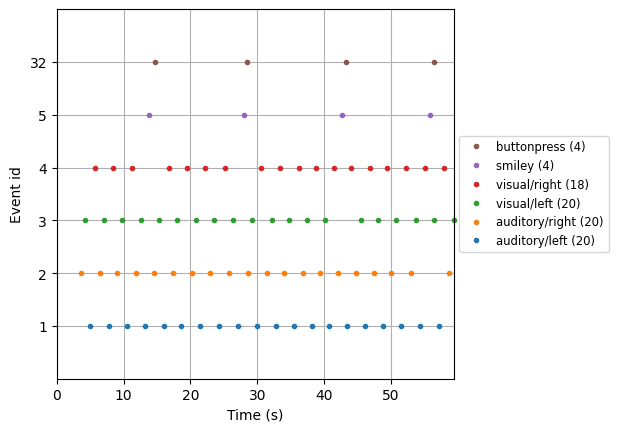

In [11]:
fig = mne.viz.plot_events(events, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp, event_id=event_dict)
fig.subplots_adjust(right=0.7)  # make room for legend

### Plotting events and raw data together

Events can also be plotted alongside the :class:`~mne.io.Raw` object they
were extracted from, by passing the Event array as the ``events`` parameter
of :meth:`raw.plot <mne.io.Raw.plot>`:



Using matplotlib as 2D backend.


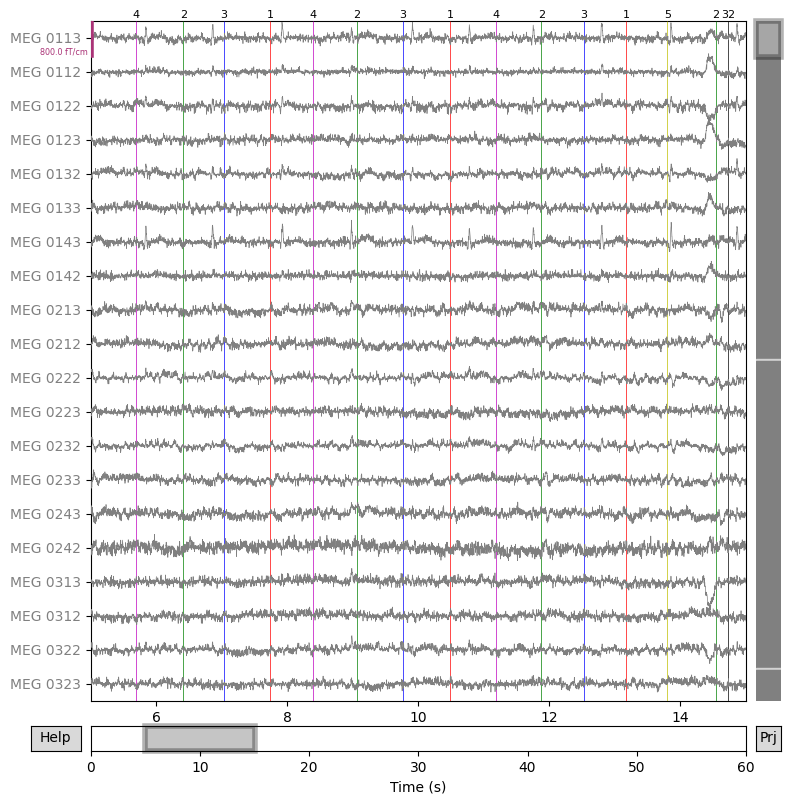

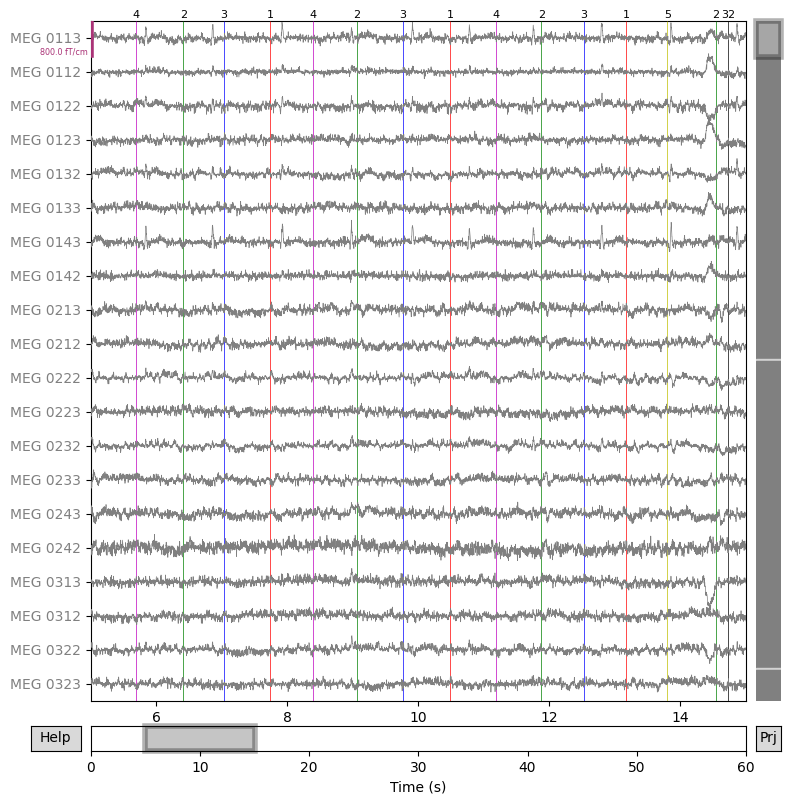

In [12]:
raw.plot(events=events, start=5, duration=10, color='gray',
         event_color={1: 'r', 2: 'g', 3: 'b', 4: 'm', 5: 'y', 32: 'k'})


## Making equally-spaced Events arrays

For some experiments (such as those intending to analyze resting-state
activity) there may not be any experimental events included in the raw
recording. In such cases, an Events array of equally-spaced events can be
generated using :func:`mne.make_fixed_length_events`:



In [13]:
new_events = mne.make_fixed_length_events(raw, start=5, stop=50, duration=2.)

By default, the events will all be given the integer Event ID of ``1``, but
you can change that with the ``id`` parameter. It is also possible to specify
an ``overlap`` duration — i.e., if you ultimately want :term:`epochs` that
are 2.5 seconds long, but you want them to overlap by 0.5 seconds, you can
specify ``duration=2.5, overlap=0.5`` in the call to
:func:`~mne.make_fixed_length_events` (this will yield the same spacing of
events as ``duration=2, overlap=0)``.

